### Importing libraries and data

In [1]:
# Importing Libraries 
import pandas as pd
# import dowhy
import numpy as np

In [2]:
# Importing the data
df_accepted = pd.read_csv('/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/data/df_trip_processed.csv')
df_rejected = pd.read_csv('/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/data/rejected.csv')
df_accepted = df_accepted.drop(columns=['Unnamed: 0'])
df_rejected = df_rejected.drop(columns=['Unnamed: 0'])

### Merging the data

In [83]:

# df_rejected.drop(columns=['id'], inplace=True)
# df_accepted.drop(columns=['speed_kmh','distance_km','time_hours','trip_end_time','lat_des','lon_des'], inplace=True)
# df_accepted[['date', 'time']] = df_accepted['trip_start_time'].str.split(' ', expand=True)
# df_accepted.drop(columns=['time'], inplace=True)
# df_accepted.drop(columns=['trip_start_time'], inplace=True)
# df_accepted.rename(columns={'Trip ID': 'order_id'}, inplace=True)
# df_accepted.rename(columns={'lat_org': 'lat'}, inplace=True)
# df_accepted.rename(columns={'lon_org': 'lng'}, inplace=True)
# df_accepted['driver_action']= 'accepted'
# df_concatenated = pd.concat([df_accepted, df_rejected], axis=0, ignore_index=True)

In [4]:
df_rejected.head(2)

,id,order_id,driver_id,driver_action,lat,lng,holiday_name,day_type,icon,date
0,2,392001,243588,rejected,6.592097,3.287445,No holiday,Weekday,rain,2021-07-01
1,3,392001,243830,rejected,6.596133,3.281784,No holiday,Weekday,rain,2021-07-01


In [5]:
df_accepted['holiday_name'].unique()

array(['No holiday', 'Id el Kabir', 'Id el Kabir additional holiday',
       'Al-Hijra Holiday', 'Isese Day', 'State Creation Anniversary Day',
       'September Equinox', 'National Day', 'Id el Maulud',
       'December Solstice', 'Sambisa Memorial Day', 'Christmas Eve',
       'Christmas Day', 'Boxing Day', 'Day off for Christmas Day',
       'Day off for Boxing Day', "New Year's Eve", "New Year's Day",
       "Day off for New Year's Day", "Valentine's Day", 'Holy Saturday',
       'Easter Monday', 'Day off for Democracy Day'], dtype=object)

In [130]:
df_accepted[df_accepted['day_type']=='weekend']

,icon,order_id,lat_org,lon_org,lat_des,lon_des,holiday_name,day_type,date,driver_action


In [3]:
df_accepted.rename(columns={'Trip ID': 'order_id'}, inplace=True)
df_rejected.rename(columns={'lat': 'lat_org'}, inplace=True)
df_rejected.rename(columns={'lng': 'lon_org'}, inplace=True)
lat_lon = df_accepted[['order_id','lat_des','lon_des']]
df_rejected = df_rejected.merge(lat_lon, on='order_id', how='left')
df_rejected

,id,order_id,driver_id,driver_action,lat_org,lon_org,holiday_name,day_type,icon,date,lat_des,lon_des
0,2,392001,243588,rejected,6.592097,3.287445,No holiday,Weekday,rain,2021-07-01,6.450107,3.391615
1,3,392001,243830,rejected,6.596133,3.281784,No holiday,Weekday,rain,2021-07-01,6.450107,3.391615
2,4,392001,243539,rejected,6.596142,3.280526,No holiday,Weekday,rain,2021-07-01,6.450107,3.391615
3,5,392001,171653,rejected,6.609232,3.288800,No holiday,Weekday,rain,2021-07-01,6.450107,3.391615
4,6,392001,245662,rejected,6.593095,3.287759,No holiday,Weekday,rain,2021-07-01,6.450107,3.391615
...,...,...,...,...,...,...,...,...,...,...,...,...
1529842,1557736,517948,243774,rejected,6.469036,3.566877,No holiday,Weekday,rain,2021-09-10,6.500608,3.598194
1529843,1557737,517948,245447,rejected,6.425431,3.527358,No holiday,Weekday,rain,2021-09-10,6.500608,3.598194
1529844,1557738,517948,239866,rejected,6.440013,3.525378,No holiday,Weekday,rain,2021-09-10,6.500608,3.598194
1529845,1557739,517948,243774,rejected,6.469036,3.566877,No holiday,Weekday,rain,2021-09-10,6.500608,3.598194


In [4]:

df_rejected.drop(columns=['id'], inplace=True)
df_accepted.drop(columns=['speed_kmh','distance_km','time_hours','trip_end_time'], inplace=True)
df_accepted[['date', 'time']] = df_accepted['trip_start_time'].str.split(' ', expand=True)
df_accepted.drop(columns=['time'], inplace=True)
df_accepted.drop(columns=['trip_start_time'], inplace=True)
df_accepted['driver_action']= 'accepted'
df_concatenated = pd.concat([df_accepted, df_rejected], axis=0, ignore_index=True)
df_concatenated

,icon,order_id,lat_org,lon_org,lat_des,lon_des,holiday_name,day_type,date,driver_action,driver_id
0,rain,391996,6.508813,3.377403,6.650970,3.345031,No holiday,Weekday,2021-07-01,accepted,NaN
1,rain,391997,6.431671,3.455538,6.428081,3.472189,No holiday,Weekday,2021-07-01,accepted,NaN
2,rain,391998,6.631679,3.338898,6.508324,3.359040,No holiday,Weekday,2021-07-01,accepted,NaN
3,rain,391999,6.572757,3.367708,6.584881,3.361407,No holiday,Weekday,2021-07-01,accepted,NaN
4,rain,392001,6.601042,3.276634,6.450107,3.391615,No holiday,Weekday,2021-07-01,accepted,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2064210,rain,517948,6.469036,3.566877,6.500608,3.598194,No holiday,Weekday,2021-09-10,rejected,243774.0
2064211,rain,517948,6.425431,3.527358,6.500608,3.598194,No holiday,Weekday,2021-09-10,rejected,245447.0
2064212,rain,517948,6.440013,3.525378,6.500608,3.598194,No holiday,Weekday,2021-09-10,rejected,239866.0
2064213,rain,517948,6.469036,3.566877,6.500608,3.598194,No holiday,Weekday,2021-09-10,rejected,243774.0


In [5]:
df_concatenated['holiday_name'].unique()

array(['No holiday', 'Id el Kabir', 'Id el Kabir additional holiday',
       'Al-Hijra Holiday', 'Isese Day', 'State Creation Anniversary Day',
       'September Equinox', 'National Day', 'Id el Maulud',
       'December Solstice', 'Sambisa Memorial Day', 'Christmas Eve',
       'Christmas Day', 'Boxing Day', 'Day off for Christmas Day',
       'Day off for Boxing Day', "New Year's Eve", "New Year's Day",
       "Day off for New Year's Day", "Valentine's Day", 'Holy Saturday',
       'Easter Monday', 'Day off for Democracy Day'], dtype=object)

### Calculating Distance 
Calculating the distance between the driver and the customer. Since that may be a cause for a driver action to accept or reject order

In [5]:
# Function to calculate the distance using latitude and longtiude 

from math import radians, sin, cos, sqrt, atan2
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # Calculate the differences
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Calculate the distance using the Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance
# Calculating the distance of each order to the mean loaction
df_concatenated['distance_to_client_km'] = df_concatenated.apply(lambda row: haversine_distance(row['lat_org'], row['lon_org'], row['lat_des'] ,row['lon_des']), axis=1)

In [6]:
df_concatenated['z_score'] = (df_concatenated['distance_to_client_km'] - df_concatenated['distance_to_client_km'].mean()) / df_concatenated['distance_to_client_km'].std()

# Identify outliers
outliers = df_concatenated[np.abs(df_concatenated['z_score']) > 3]
outliers

,icon,order_id,lat_org,lon_org,lat_des,lon_des,holiday_name,day_type,date,driver_action,driver_id,distance_to_client_km,z_score
20,rain,392040,6.500608,3.598194,6.480557,3.280383,No holiday,Weekday,2021-07-01,accepted,NaN,35.183192,3.243335
131,rain,392276,6.688165,3.225946,6.456072,3.481103,No holiday,Weekday,2021-07-01,accepted,NaN,38.216039,3.625066
168,rain,392336,6.470242,3.565444,6.662884,3.326068,No holiday,Weekday,2021-07-01,accepted,NaN,34.030430,3.098241
515,rain,392943,6.474644,3.742272,6.453448,3.434063,No holiday,Weekday,2021-07-01,accepted,NaN,34.134868,3.111386
708,rain,393272,6.458535,3.237907,6.448425,3.550224,No holiday,Weekday,2021-07-01,accepted,NaN,34.526328,3.160658
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059080,rain,448336,6.441212,3.521784,6.463439,3.185237,No holiday,Weekday,2021-07-09,rejected,243585.0,37.267377,3.505662
2059081,rain,448336,6.424900,3.529549,6.463439,3.185237,No holiday,Weekday,2021-07-09,rejected,243469.0,38.284416,3.633673
2059082,rain,448336,6.433801,3.489242,6.463439,3.185237,No holiday,Weekday,2021-07-09,rejected,244193.0,33.751290,3.063107
2059083,rain,448336,6.443700,3.528938,6.463439,3.185237,No holiday,Weekday,2021-07-09,rejected,244218.0,38.039057,3.602790


Calculating Z score to drop outliers

In [7]:
df_cleaned = df_concatenated[np.abs(df_concatenated['z_score']) <= 3]

# Drop the z_score column as it's no longer needed
df_concatenated = df_cleaned.drop(columns=['z_score'])

df_concatenated

,icon,order_id,lat_org,lon_org,lat_des,lon_des,holiday_name,day_type,date,driver_action,driver_id,distance_to_client_km
0,rain,391996,6.508813,3.377403,6.650970,3.345031,No holiday,Weekday,2021-07-01,accepted,NaN,16.206549
1,rain,391997,6.431671,3.455538,6.428081,3.472189,No holiday,Weekday,2021-07-01,accepted,NaN,1.882675
2,rain,391998,6.631679,3.338898,6.508324,3.359040,No holiday,Weekday,2021-07-01,accepted,NaN,13.895773
3,rain,391999,6.572757,3.367708,6.584881,3.361407,No holiday,Weekday,2021-07-01,accepted,NaN,1.517186
4,rain,392001,6.601042,3.276634,6.450107,3.391615,No holiday,Weekday,2021-07-01,accepted,NaN,21.048262
...,...,...,...,...,...,...,...,...,...,...,...,...
2064210,rain,517948,6.469036,3.566877,6.500608,3.598194,No holiday,Weekday,2021-09-10,rejected,243774.0,4.929145
2064211,rain,517948,6.425431,3.527358,6.500608,3.598194,No holiday,Weekday,2021-09-10,rejected,245447.0,11.451298
2064212,rain,517948,6.440013,3.525378,6.500608,3.598194,No holiday,Weekday,2021-09-10,rejected,239866.0,10.493954
2064213,rain,517948,6.469036,3.566877,6.500608,3.598194,No holiday,Weekday,2021-09-10,rejected,243774.0,4.929145


### Using CausalNex 

### Casual Inferance
Using CasualNex to discover casual relationship between variables and make intervation to improve order fulfilment.


create an empty structure model.

In [10]:

import warnings
from causalnex.structure import StructureModel

warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()

In [11]:
sm.add_edges_from([
    ('holiday_name', 'driver_action'),
    ('day_type', 'driver_action')
])

In [47]:
sm.edges

OutEdgeView([('holiday_name', 'driver_action'), ('day_type', 'driver_action')])

In [ ]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show('/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/01_simple_plot.html')

### Learning the structure model from data. 
In CasualNEX the structure learning algorithm is the NOTEARS algorithm

### Preparing the Data for Structure Learning

In [61]:
df_concatenated.columns

Index(['icon', 'lat_org', 'lon_org', 'lat_des', 'lon_des', 'holiday_name',
       'day_type', 'driver_action', 'distance_to_client_km'],
      dtype='object')

In [8]:

drop_col2 = ['driver_id','order_id', 'date']
data2= df_concatenated.drop(columns=drop_col2,inplace=True)
data2

In [9]:
data2 = df_concatenated
data2

,icon,lat_org,lon_org,lat_des,lon_des,holiday_name,day_type,driver_action,distance_to_client_km
0,rain,6.508813,3.377403,6.650970,3.345031,No holiday,Weekday,accepted,16.206549
1,rain,6.431671,3.455538,6.428081,3.472189,No holiday,Weekday,accepted,1.882675
2,rain,6.631679,3.338898,6.508324,3.359040,No holiday,Weekday,accepted,13.895773
3,rain,6.572757,3.367708,6.584881,3.361407,No holiday,Weekday,accepted,1.517186
4,rain,6.601042,3.276634,6.450107,3.391615,No holiday,Weekday,accepted,21.048262
...,...,...,...,...,...,...,...,...,...
2064210,rain,6.469036,3.566877,6.500608,3.598194,No holiday,Weekday,rejected,4.929145
2064211,rain,6.425431,3.527358,6.500608,3.598194,No holiday,Weekday,rejected,11.451298
2064212,rain,6.440013,3.525378,6.500608,3.598194,No holiday,Weekday,rejected,10.493954
2064213,rain,6.469036,3.566877,6.500608,3.598194,No holiday,Weekday,rejected,4.929145


In [16]:

import numpy as np

struct_data2 = data2.copy()
non_numeric_columns2 = list(struct_data2.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns2)

['icon', 'holiday_name', 'day_type', 'driver_action']


In [17]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns2:
    struct_data2[col] = le.fit_transform(struct_data2[col])

struct_data2.head(5)

,icon,lat_org,lon_org,lat_des,lon_des,holiday_name,day_type,driver_action,distance_to_client_km
0,2,6.508813,3.377403,6.650970,3.345031,18,0,0,16.206549
1,2,6.431671,3.455538,6.428081,3.472189,18,0,0,1.882675
2,2,6.631679,3.338898,6.508324,3.359040,18,0,0,13.895773
3,2,6.572757,3.367708,6.584881,3.361407,18,0,0,1.517186
4,2,6.601042,3.276634,6.450107,3.391615,18,0,0,21.048262


### Applying the NOTEARS algorithm to learn the structure.

In [22]:
from causalnex.structure.notears import from_pandas
sm2 = from_pandas(struct_data2)

In [25]:
import pickle
with open('structure_model.pkl', 'wb') as file:
    pickle.dump(sm2, file)

In [26]:
import pickle

# Load the structure model from the file
with open('structure_model.pkl', 'rb') as file:
    sm_loaded = pickle.load(file)

# Verify that the loaded model is correct
print(sm_loaded.edges)


[('icon', 'lat_org'), ('icon', 'lon_org'), ('icon', 'lat_des'), ('icon', 'lon_des'), ('icon', 'holiday_name'), ('icon', 'day_type'), ('icon', 'driver_action'), ('icon', 'distance_to_client_km'), ('lat_org', 'icon'), ('lat_org', 'lon_org'), ('lat_org', 'lat_des'), ('lat_org', 'lon_des'), ('lat_org', 'holiday_name'), ('lat_org', 'day_type'), ('lat_org', 'driver_action'), ('lat_org', 'distance_to_client_km'), ('lon_org', 'icon'), ('lon_org', 'lat_org'), ('lon_org', 'lat_des'), ('lon_org', 'lon_des'), ('lon_org', 'holiday_name'), ('lon_org', 'day_type'), ('lon_org', 'driver_action'), ('lon_org', 'distance_to_client_km'), ('lat_des', 'icon'), ('lat_des', 'lat_org'), ('lat_des', 'lon_org'), ('lat_des', 'lon_des'), ('lat_des', 'holiday_name'), ('lat_des', 'day_type'), ('lat_des', 'driver_action'), ('lat_des', 'distance_to_client_km'), ('lon_des', 'icon'), ('lon_des', 'lat_org'), ('lon_des', 'lon_org'), ('lon_des', 'lat_des'), ('lon_des', 'holiday_name'), ('lon_des', 'day_type'), ('lon_des', '

In [ ]:

viz = plot_structure(
    sm2,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

viz.toggle_physics(False)
viz.show("/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/01_fully_connected.html")

In [ ]:
sm2.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm2,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
viz.show("/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/01_thresholded.html")

In [123]:
# sm.remove_node("icon")
# sm.remove_node("holiday_name")
# sm.remove_edge("day_type","date")
sm.remove_node("date")
sm.remove_node("day_type")

### Suggested Casual Graph from LLM (Using Domain Knowladge)

In [16]:
import networkx as nx
from causalnex.structure import StructureModel

# Define the suggested graph
suggested_edges = [

    ('distance_to_client_km', 'driver_action'),
    ('holiday_name', 'driver_action'),
    ('day_type', 'driver_action'),
    ('icon', 'driver_action')
]

# Create a StructureModel
suggested_sm = StructureModel()
suggested_sm.add_edges_from(suggested_edges)


In [69]:

viz = plot_structure(
    suggested_sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

viz.toggle_physics(False)
viz.show("/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/suggested.html")

/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/suggested.html


In [39]:
learned_edges = set(sm2.edges())
suggested_edges_set = set(suggested_sm.edges())

# Print edges that are in the suggested graph but not in the learned graph
print("Edges in the suggested graph but not in the learned graph:")
print(suggested_edges_set - learned_edges)

# Print edges that are in the learned graph but not in the suggested graph
print("Edges in the learned graph but not in the suggested graph:")
print(learned_edges - suggested_edges_set)

Edges in the suggested graph but not in the learned graph:
{('day_type', 'driver_action'), ('holiday_name', 'driver_action'), ('distance_to_client_km', 'driver_action')}
Edges in the learned graph but not in the suggested graph:
{('lat_org', 'holiday_name'), ('lon_des', 'lon_org'), ('lon_org', 'lat_des'), ('lat_des', 'lat_org'), ('icon', 'lon_des'), ('day_type', 'icon'), ('driver_action', 'icon'), ('driver_action', 'distance_to_client_km')}


In [ ]:

viz = plot_structure(
    suggested_sm,
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)

viz.toggle_physics(False)
viz.show("/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/plots/diffrence.html")

### Fitting the Conditional Distribution of the Bayesian Network

In [17]:
from causalnex.network import BayesianNetwork
bn_suggested = BayesianNetwork(suggested_sm)

/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
struct_data2

,icon,lat_org,lon_org,lat_des,lon_des,holiday_name,day_type,driver_action,distance_to_client_km
0,2,6.508813,3.377403,6.650970,3.345031,18,0,0,16.206549
1,2,6.431671,3.455538,6.428081,3.472189,18,0,0,1.882675
2,2,6.631679,3.338898,6.508324,3.359040,18,0,0,13.895773
3,2,6.572757,3.367708,6.584881,3.361407,18,0,0,1.517186
4,2,6.601042,3.276634,6.450107,3.391615,18,0,0,21.048262
...,...,...,...,...,...,...,...,...,...
2064210,2,6.469036,3.566877,6.500608,3.598194,18,0,1,4.929145
2064211,2,6.425431,3.527358,6.500608,3.598194,18,0,1,11.451298
2064212,2,6.440013,3.525378,6.500608,3.598194,18,0,1,10.493954
2064213,2,6.469036,3.566877,6.500608,3.598194,18,0,1,4.929145


### Preparing the Discretised Data

In [10]:
discretised_data = data2.copy()

In [11]:
discretised_data

,icon,lat_org,lon_org,lat_des,lon_des,holiday_name,day_type,driver_action,distance_to_client_km
0,rain,6.508813,3.377403,6.650970,3.345031,No holiday,Weekday,accepted,16.206549
1,rain,6.431671,3.455538,6.428081,3.472189,No holiday,Weekday,accepted,1.882675
2,rain,6.631679,3.338898,6.508324,3.359040,No holiday,Weekday,accepted,13.895773
3,rain,6.572757,3.367708,6.584881,3.361407,No holiday,Weekday,accepted,1.517186
4,rain,6.601042,3.276634,6.450107,3.391615,No holiday,Weekday,accepted,21.048262
...,...,...,...,...,...,...,...,...,...
2064210,rain,6.469036,3.566877,6.500608,3.598194,No holiday,Weekday,rejected,4.929145
2064211,rain,6.425431,3.527358,6.500608,3.598194,No holiday,Weekday,rejected,11.451298
2064212,rain,6.440013,3.525378,6.500608,3.598194,No holiday,Weekday,rejected,10.493954
2064213,rain,6.469036,3.566877,6.500608,3.598194,No holiday,Weekday,rejected,4.929145


In [12]:
discretised_data = discretised_data.drop(columns=['lat_org'])
discretised_data = discretised_data.drop(columns=['lon_org'])
discretised_data = discretised_data.drop(columns=['lat_des'])
discretised_data = discretised_data.drop(columns=['lon_des'])
discretised_data 

,icon,holiday_name,day_type,driver_action,distance_to_client_km
0,rain,No holiday,Weekday,accepted,16.206549
1,rain,No holiday,Weekday,accepted,1.882675
2,rain,No holiday,Weekday,accepted,13.895773
3,rain,No holiday,Weekday,accepted,1.517186
4,rain,No holiday,Weekday,accepted,21.048262
...,...,...,...,...,...
2064210,rain,No holiday,Weekday,rejected,4.929145
2064211,rain,No holiday,Weekday,rejected,11.451298
2064212,rain,No holiday,Weekday,rejected,10.493954
2064213,rain,No holiday,Weekday,rejected,4.929145


In [13]:
number_of_buckets = 4
discretised_data['distance_to_client_km'] = pd.qcut(discretised_data['distance_to_client_km'], q=number_of_buckets, labels=False, duplicates='drop')

# Map numerical labels to meaningful categories
category_labels = {0: 'Very Short', 1: 'Short', 2: 'Medium', 3: 'Long'}
discretised_data['distance_to_client_km'] = discretised_data['distance_to_client_km'].map(category_labels)

# Display the DataFrame
discretised_data



,icon,holiday_name,day_type,driver_action,distance_to_client_km
0,rain,No holiday,Weekday,accepted,Long
1,rain,No holiday,Weekday,accepted,Very Short
2,rain,No holiday,Weekday,accepted,Long
3,rain,No holiday,Weekday,accepted,Very Short
4,rain,No holiday,Weekday,accepted,Long
...,...,...,...,...,...
2064210,rain,No holiday,Weekday,rejected,Short
2064211,rain,No holiday,Weekday,rejected,Medium
2064212,rain,No holiday,Weekday,rejected,Medium
2064213,rain,No holiday,Weekday,rejected,Short


### Train / Test Split

In [14]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

###  Model Probability

In [18]:
bn_suggested = bn_suggested.fit_node_states(discretised_data)

### Fit Conditional Probability Distributions

In [19]:
bn_suggested = bn_suggested.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [20]:
bn_suggested.cpds["driver_action"]

day_type                       Weekday                                   \
distance_to_client_km             Long                                    
holiday_name          Al-Hijra Holiday                                    
icon                         clear-day partly-cloudy-day      rain wind   
driver_action                                                             
accepted                           0.5          0.909091  0.999527  0.5   
rejected                           0.5          0.090909  0.000473  0.5   

day_type                                                                    \
distance_to_client_km                                                        
holiday_name          Boxing Day                             Christmas Day   
icon                   clear-day partly-cloudy-day rain wind     clear-day   
driver_action                                                                
accepted                     0.5          0.888889  0.5  0.5           0.5   
rejected                     0.5          0.111111  0.5  0.5           0.5   

day_type                                 ...           Weekend       \
distance_to_client_km                    ...        Very Short        
holiday_name                             ... September Equinox        
icon                  partly-cloudy-day  ...              rain wind   
driver_action                            ...                          
accepted                            0.5  ...               0.5  0.5   
rejected                            0.5  ...               0.5  0.5   

day_type                                                                      \
distance_to_client_km                                                          
holiday_name          State Creation Anniversary Day                           
icon                                       clear-day partly-cloudy-day  rain   
driver_action                                                                  
accepted                                         0.5               0.5  0.75   
rejected                                         0.5               0.5  0.25   

day_type                                                                
distance_to_client_km                                                   
holiday_name               Valentine's Day                              
icon                  wind       clear-day partly-cloudy-day rain wind  
driver_action                                                           
accepted               0.5             0.5               0.5  0.5  0.5  
rejected               0.5             0.5               0.5  0.5  0.5  

[2 rows x 736 columns]

In [30]:
discretised_data.loc[9, discretised_data.columns != 'driver_action']

icon                           rain
holiday_name             No holiday
day_type                    Weekday
distance_to_client_km    Very Short
Name: 9, dtype: object

In [32]:

predictions = bn_suggested.predict(discretised_data, "driver_action")
print(f"The prediction is '{predictions.loc[9, 'driver_action_prediction']}'")

The prediction is 'rejected'


Let’s compare this to the ground truth:

In [33]:
print(f"The ground truth is '{discretised_data.loc[9, 'driver_action']}'")

The ground truth is 'accepted'


### Classification Report

In [34]:
from causalnex.evaluation import classification_report

classification_report(bn_suggested, test, "driver_action")

{'driver_action_accepted': {'precision': 0.9976719823070656,
  'recall': 0.16246185340333985,
  'f1-score': 0.27942231205581275,
  'support': 52757.0},
 'driver_action_rejected': {'precision': 0.7752949552481693,
  'recall': 0.9998688300956229,
  'f1-score': 0.8733766047766632,
  'support': 152474.0},
 'accuracy': 0.7846036904756104,
 'macro avg': {'precision': 0.8864834687776174,
  'recall': 0.5811653417494813,
  'f1-score': 0.576399458416238,
  'support': 205231.0},
 'weighted avg': {'precision': 0.8324595396264853,
  'recall': 0.7846036904756104,
  'f1-score': 0.7206937906741451,
  'support': 205231.0}}

### Querying Marginals
Baseline Marginals

In [35]:
bn_suggested = bn_suggested.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

In [36]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn_suggested)
marginals = ie.query()
marginals["driver_action"]

{'accepted': 0.2766152310926944, 'rejected': 0.7233847689073054}

In [37]:
import numpy as np

labels, counts = np.unique(discretised_data["driver_action"], return_counts=True)
list(zip(labels, counts))

[('accepted', 527214), ('rejected', 1525087)]

In [39]:
marginals_short = ie.query({"day_type": "Weekday"})
marginals_long = ie.query({"day_type": "Weekend"})
print("Marginal driver_action | Weekday", marginals_short["driver_action"])
print("Marginal driver_action | Weekend", marginals_long["driver_action"])

Marginal driver_action | Weekday {'accepted': 0.2349339894685699, 'rejected': 0.7650660105314302}
Marginal driver_action | Weekend {'accepted': 0.5171119708340131, 'rejected': 0.482888029165987}


### Do Calculus
Updating a Node Distribution

In [41]:

print("distribution before do", ie.query()["distance_to_client_km"])
ie.do_intervention("distance_to_client_km",
                   {'Short': 1,
                    'Long': 0.0,
                    'Medium':0.0,
                    'Very Short':0.0
                    
                    })
print("distribution after do", ie.query()["distance_to_client_km"])

distribution before do {'Long': 0.2499998781857473, 'Medium': 0.24999987818574732, 'Short': 0.2499969546436813, 'Very Short': 0.2500032889848244}
distribution after do {'Long': 0.0, 'Medium': 0.0, 'Short': 1.000000000000001, 'Very Short': 0.0}


In [42]:

print("Marginal driver_action", ie.query()["driver_action"])
ie.do_intervention("distance_to_client_km",
                   {'Short': 1,
                    'Long': 0.0,
                    'Medium':0.0,
                    'Very Short':0.0
                    
                    })
print("updating Marginal driver_action", ie.query()["driver_action"])

Marginal driver_action {'accepted': 0.21283113165219425, 'rejected': 0.7871688683478063}
updating Marginal driver_action {'accepted': 0.21283113165219425, 'rejected': 0.7871688683478063}


In [43]:

print("Marginal driver_action", ie.query()["driver_action"])
ie.do_intervention("distance_to_client_km",
                   {'Short': 0.0,
                    'Long': 0.0,
                    'Medium':0.0,
                    'Very Short':1
                    
                    })
print("updating Marginal driver_action", ie.query()["driver_action"])

Marginal driver_action {'accepted': 0.21283113165219425, 'rejected': 0.7871688683478063}
updating Marginal driver_action {'accepted': 0.2190325832144563, 'rejected': 0.7809674167855447}


In [49]:
previous = round(0.21283113165219425*100)
now = round(0.2190325832144563*100)
increase = now - previous

print(f'If all the custemers distance to the driver is very short the acceptance rate of a drver increse form {previous}% to {now}% increae by {increase}%')

If all the custemers distance to the driver is very short the acceptance rate of a drver increse form 21% to 22% increae by 1%


accepted = 0 rejected =1

In [89]:
test.columns

Index(['icon', 'holiday_name', 'day_type', 'driver_action',
       'distance_to_client_km'],
      dtype='object')

In [90]:

from causalnex.evaluation import classification_report

classification_report(bn_suggested, test, "distance_to_client_km")

KeyError: 'distance_to_client_km'

In [ ]:
from causalnex.discretiser import Discretiser
# Define the number of bins
num_bins = 4

# Discretize latitude
struct_data2['lat_org'] = Discretiser(method="quantile", num_buckets=num_bins).transform(struct_data2['lat_org'].values)

# Discretize longitude
struct_data2['lon_org'] = Discretiser(method="quantile", num_buckets=num_bins).transform(struct_data2['lon_org'].values)
struct_data2['lat_des'] = Discretiser(method="quantile", num_buckets=num_bins).transform(struct_data2['lat_des'].values)

# Discretize longitude
struct_data2['lon_ddes'] = Discretiser(method="quantile", num_buckets=num_bins).transform(struct_data2['lon_des'].values)

discretiser = Discretiser(method="quantile", num_buckets=num_bins)
struct_data2['distance_to_client_km'] = discretiser.transform(struct_data2['distance_to_client_km'].values.reshape(-1, 1))
# Verify the results
print(struct_data2)


In [59]:
import pandas as pd
from causalnex.discretiser import Discretiser
from causalnex.discretiser.discretiser_strategy import DecisionTreeSupervisedDiscretiserMethod

discretiser = DecisionTreeSupervisedDiscretiserMethod(
    mode="single"
)

# Fit the discretizer and transform the data
continuous_columns = ["lat_org", "lon_org", "lat_des", "lon_des", "distance_to_client_km"]
for col in continuous_columns:
    discretiser.fit(struct_data2[col].values.reshape(-1, 1), struct_data2["driver_action"].values)
    struct_data2[col] = discretiser.transform(struct_data2[col].values.reshape(-1, 1))

# The resulting dataframe will have the continuous columns discretized
print(struct_data2)

TypeError: DecisionTreeSupervisedDiscretiserMethod.fit() missing 2 required positional arguments: 'dataframe' and 'target_continuous'

In [48]:
# Sample 10% of the data
df_sample = struct_data2.sample(frac=0.05, random_state=42)


In [ ]:
from causalnex.network import BayesianNetwork

# Fit the model
bn_suggested = bn_suggested.fit_node_states_and_cpds(df_sample)

In [ ]:

import networkx as nx

nx.drawing.nx_pydot.write_dot(sm, 'graph.dot')

In [ ]:
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
import matplotlib.pyplot as plt

# Plot the learned structure
viz_learned = plot_structure(
    sm2,
    # graph_attributes={"scale": "1.0"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
plt.title("Learned Structure")
plt.show()

# Plot the suggested structure
viz_suggested = plot_structure(
    suggested_sm,
    # graph_attributes={"scale": "1.0"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
plt.title("Suggested Structure")
plt.show()


In [ ]:
g = """digraph {

icon;
holiday_name;
day_type;
date;
driver_action;
distance_to_centroid_km;

icon -> driver_action;
holiday_name -> driver_action;
day_type -> driver_action;
date -> driver_action;
distance_to_centroid_km -> driver_action;

}"""

### dowhy

In [60]:
suggested_edges = """digraph {
    lat_org;
    lon_org;
    lat_des;
    lon_des;
    distance_to_client_km;
    holiday_name;
    driver_action;
    day_type;
    lat_org -> distance_to_client_km;
    lon_org -> distance_to_client_km;
    lat_des -> distance_to_client_km;
    lon_des -> distance_to_client_km;
    distance_to_client_km -> driver_action;
    holiday_name -> driver_action;
    day_type -> driver_action;
}"""

In [ ]:
from dowhy import CausalModel

treatment_col = 'day_type'
outcome_col = 'driver_action'
model_suggested=CausalModel(
    data = df_sample,
    treatment=treatment_col,
    outcome=outcome_col,
    graph=suggested_edges)

model2.view_model()

In [61]:
struct_data2

,icon,lat_org,lon_org,lat_des,lon_des,holiday_name,day_type,driver_action,distance_to_client_km
0,2,6.508813,3.377403,6.650970,3.345031,18,0,0,16.206549
1,2,6.431671,3.455538,6.428081,3.472189,18,0,0,1.882675
2,2,6.631679,3.338898,6.508324,3.359040,18,0,0,13.895773
3,2,6.572757,3.367708,6.584881,3.361407,18,0,0,1.517186
4,2,6.601042,3.276634,6.450107,3.391615,18,0,0,21.048262
...,...,...,...,...,...,...,...,...,...
2064210,2,6.469036,3.566877,6.500608,3.598194,18,0,1,4.929145
2064211,2,6.425431,3.527358,6.500608,3.598194,18,0,1,11.451298
2064212,2,6.440013,3.525378,6.500608,3.598194,18,0,1,10.493954
2064213,2,6.469036,3.566877,6.500608,3.598194,18,0,1,4.929145


In [104]:
df_sample = df_concatenated.sample(n=200, random_state=42)
df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,Weekday,2021-07-08,rejected,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,Weekday,2021-07-07,rejected,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,Weekday,2021-07-06,rejected,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,Weekday,2021-09-28,accepted,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,Weekend,2021-07-03,rejected,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,Weekend,2021-07-03,rejected,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,Weekday,2021-07-06,rejected,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,Weekday,2021-07-01,rejected,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,Weekday,2021-07-01,rejected,139750.0,242884.0,5.602618


In [49]:
# Convert 'holiday_name' to numeric based on condition
# Assuming df_sample is your DataFrame with 'driver_action' column
df_sample['driver_action'] = np.where(df_sample['driver_action'] == 'rejected', 0, 1)

# Convert to integer type if needed (though np.where will ensure integers)
df_sample['driver_action'] = df_sample['driver_action'].astype(int)

print(df_sample)

                      icon  order_id       lat       lng holiday_name  \
1888836               rain    436877  6.433474  3.494433   No holiday   
1709785               rain    430013  6.526287  3.367707   No holiday   
1511112  partly-cloudy-day    425319  6.518392  3.353533   No holiday   
246953                rain    944862  6.481890  3.369439   No holiday   
943402                rain    407957  6.596473  3.338337   No holiday   
251073   partly-cloudy-day    953229  6.594051  3.341678   No holiday   
926041                rain    407222  6.557803  3.360702   No holiday   
1046706               rain    412175  6.665881  3.373062   No holiday   
419902                rain   1322630  6.525837  3.395278   No holiday   
651944                rain    396889  6.567582  3.367077   No holiday   
505372   partly-cloudy-day   1526213  6.501229  3.353544   No holiday   
849589                rain    404337  6.544338  3.363482   No holiday   
844286                rain    404178  6.600522  3.3

In [87]:
df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,Weekday,2021-07-08,rejected,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,Weekday,2021-07-07,rejected,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,Weekday,2021-07-06,rejected,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,Weekday,2021-09-28,accepted,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,Weekend,2021-07-03,rejected,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,Weekend,2021-07-03,rejected,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,Weekday,2021-07-06,rejected,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,Weekday,2021-07-01,rejected,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,Weekday,2021-07-01,rejected,139750.0,242884.0,5.602618


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import sklearn

def preprocess_data(data):
    # Fill missing values
    data = data.fillna(method='ffill').fillna(method='bfill')
    
    # Encode categorical variables (including strings)
    categorical_cols = data.select_dtypes(include=['object', 'category']).columns
    
    # Check the version of scikit-learn
    sklearn_version = sklearn.__version__
    if sklearn_version < "1.2.0":
        encoder = OneHotEncoder(drop='first', sparse=False)
    else:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
    
    # Apply OneHotEncoder to categorical columns
    encoded_data = pd.DataFrame(encoder.fit_transform(data[categorical_cols]))
    encoded_data.columns = encoder.get_feature_names_out(categorical_cols)
    encoded_data.index = data.index
    
    # Drop original categorical columns and concatenate the encoded columns
    data = data.drop(categorical_cols, axis=1)
    data = pd.concat([data, encoded_data], axis=1)
    
    # Ensure all data is numeric
    data = data.apply(pd.to_numeric)
    
    return data

# Assuming `df` is your DataFrame
data = preprocess_data(df_head)

# Check the data types to ensure they are all numeric
print(data.dtypes)

order_id                     int64
lat                        float64
lng                        float64
driver_id                  float64
distance_to_centroid_km    float64
dtype: object


/tmp/ipykernel_231698/711918826.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')


In [84]:
df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,1,2021-07-08,rejected,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,1,2021-07-07,rejected,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,1,2021-07-06,rejected,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,1,2021-09-28,accepted,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,1,2021-07-03,rejected,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,1,2021-07-03,rejected,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,1,2021-07-06,rejected,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,1,2021-07-01,rejected,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,1,2021-07-01,rejected,139750.0,242884.0,5.602618


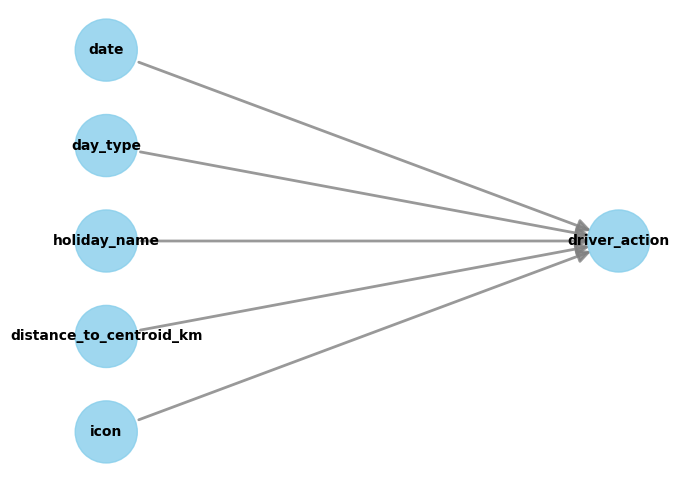

In [22]:
from dowhy import CausalModel

treatment_col = 'day_type'
outcome_col = 'driver_action'
model2=CausalModel(
    data = df_sample,
    treatment=treatment_col,
    outcome=outcome_col,
    graph=g)

model2.view_model()

In [23]:
identified_estimand = model2.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)  # Explore methods proposed

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                       
───────────(E[driver_action])
d[day_type]                  
Estimand assumption 1, Unconfoundedness: If U→{day_type} and U→driver_action then P(driver_action|day_type,,U) = P(driver_action|day_type,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [128]:
df_sample[self._target_estimand.treatment_variable]


NameError: name 'self' is not defined

In [25]:
#method = "backdoor.propensity_score_weighting"
method = "backdoor.linear_regression"

desired_effect = "ate"

estimate = model2.estimate_effect(
    identified_estimand,
    method_name=method,
    target_units=desired_effect,                         
    method_params={"weighting_scheme":"ips_weight"})

print("Causal Estimate is " + str(estimate.value))

/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


ValueError: Found unknown categories [1] in column 0 during transform

In [38]:
df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,Weekday,2021-07-08,0,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,Weekday,2021-07-07,0,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,Weekday,2021-07-06,0,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,Weekday,2021-09-28,1,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,Weekend,2021-07-03,0,416976.0,195104.0,8.534560
251073,partly-cloudy-day,953229,6.594051,3.341678,No holiday,Weekday,2021-09-29,1,NaN,NaN,8.101650
926041,rain,407222,6.557803,3.360702,No holiday,Weekend,2021-07-03,0,399245.0,243899.0,3.637285
1046706,rain,412175,6.665881,3.373062,No holiday,Weekend,2021-07-04,0,522057.0,244122.0,14.688552
419902,rain,1322630,6.525837,3.395278,No holiday,Weekday,2021-11-22,1,NaN,NaN,1.599771
651944,rain,396889,6.567582,3.367077,No holiday,Weekday,2021-07-01,0,120459.0,203389.0,4.131910


In [61]:
# Fit OneHotEncoder on the full data
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoder.fit(df_sample[['day_type']])

# Transform the treatment column
encoded_columns = encoder.transform(df_sample[['day_type']]).toarray()
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['day_type']))
df_sample_encoded = df_sample.join(encoded_df).drop(columns=['day_type'])

In [94]:
df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,1,2021-07-08,rejected,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,1,2021-07-07,rejected,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,1,2021-07-06,rejected,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,1,2021-09-28,accepted,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,1,2021-07-03,rejected,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,1,2021-07-03,rejected,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,1,2021-07-06,rejected,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,1,2021-07-01,rejected,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,1,2021-07-01,rejected,139750.0,242884.0,5.602618


In [105]:
df_sample['day_type'] = np.where(df_sample['day_type'] == 'Weekday', 0, 1)

# Convert to integer type if needed (though np.where will ensure integers)
df_sample['day_type'] = df_sample['day_type'].astype(int)

df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,0,2021-07-08,rejected,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,0,2021-07-07,rejected,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,0,2021-07-06,rejected,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,0,2021-09-28,accepted,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,1,2021-07-03,rejected,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,1,2021-07-03,rejected,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,0,2021-07-06,rejected,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,0,2021-07-01,rejected,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,0,2021-07-01,rejected,139750.0,242884.0,5.602618


In [115]:
df_sample['driver_action'] = np.where(df_sample['driver_action'] == 'rejected', 0, 1)

# Convert to integer type if needed (though np.where will ensure integers)
df_sample['driver_action'] = df_sample['driver_action'].astype(int)

df_sample

,icon,order_id,lat,lng,holiday_name,day_type,date,driver_action,id,driver_id,distance_to_centroid_km
1888836,rain,436877,6.433474,3.494433,No holiday,0,2021-07-08,0,1376880.0,243624.0,16.603329
1709785,rain,430013,6.526287,3.367707,No holiday,0,2021-07-07,0,1194210.0,243915.0,1.952368
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,0,2021-07-06,0,993066.0,245502.0,3.746566
246953,rain,944862,6.481890,3.369439,No holiday,0,2021-09-28,1,NaN,NaN,6.019060
943402,rain,407957,6.596473,3.338337,No holiday,1,2021-07-03,0,416976.0,195104.0,8.534560
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,1,2021-07-03,0,444171.0,243994.0,10.125713
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,0,2021-07-06,0,1009886.0,243514.0,2.135138
582297,rain,394332,6.541290,3.368442,No holiday,0,2021-07-01,0,49215.0,243756.0,1.840056
670836,rain,397680,6.584100,3.376537,No holiday,0,2021-07-01,0,139750.0,242884.0,5.602618


In [98]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')
encoded_columns = encoder.fit_transform(df_sample[['day_type']]).toarray()
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['day_type']))
df_sample_encoded = df_sample.join(encoded_df).drop(columns=['day_type'])
df_sample_encoded['day_type_1']

,icon,order_id,lat,lng,holiday_name,date,driver_action,id,driver_id,distance_to_centroid_km,day_type_1
1888836,rain,436877,6.433474,3.494433,No holiday,2021-07-08,rejected,1376880.0,243624.0,16.603329,NaN
1709785,rain,430013,6.526287,3.367707,No holiday,2021-07-07,rejected,1194210.0,243915.0,1.952368,NaN
1511112,partly-cloudy-day,425319,6.518392,3.353533,No holiday,2021-07-06,rejected,993066.0,245502.0,3.746566,NaN
246953,rain,944862,6.481890,3.369439,No holiday,2021-09-28,accepted,NaN,NaN,6.019060,NaN
943402,rain,407957,6.596473,3.338337,No holiday,2021-07-03,rejected,416976.0,195104.0,8.534560,NaN
...,...,...,...,...,...,...,...,...,...,...,...
970044,rain,409065,6.603984,3.324610,No holiday,2021-07-03,rejected,444171.0,243994.0,10.125713,NaN
1527724,partly-cloudy-day,425736,6.547920,3.369975,No holiday,2021-07-06,rejected,1009886.0,243514.0,2.135138,NaN
582297,rain,394332,6.541290,3.368442,No holiday,2021-07-01,rejected,49215.0,243756.0,1.840056,NaN
670836,rain,397680,6.584100,3.376537,No holiday,2021-07-01,rejected,139750.0,242884.0,5.602618,NaN


In [118]:
df_sample['driver_action'].dtype

dtype('int64')

In [116]:
g = """digraph {

icon;
holiday_name;
day_type;
date;
driver_action;
distance_to_centroid_km;

icon -> driver_action;
holiday_name -> driver_action;
day_type -> driver_action;
date -> driver_action;
distance_to_centroid_km -> driver_action;

}"""

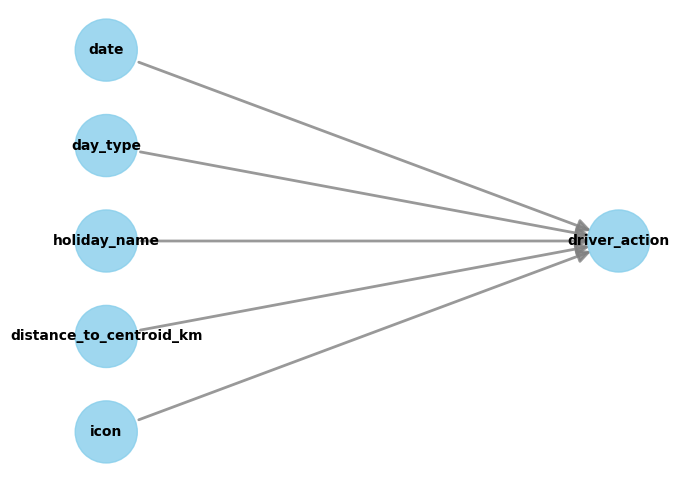

In [119]:
from dowhy import CausalModel

# Define treatment and outcome columns
treatment_col = 'day_type'
outcome_col = 'driver_action'

# Create the causal model
model5 = CausalModel(
    data=df_sample,
    treatment=treatment_col,
    outcome=outcome_col,
    graph=g
)

# Visualize the model
model5.view_model()


In [120]:
# Identify the causal effect
identified_estimand = model5.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                       
───────────(E[driver_action])
d[day_type]                  
Estimand assumption 1, Unconfoundedness: If U→{day_type} and U→driver_action then P(driver_action|day_type,,U) = P(driver_action|day_type,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [122]:
# Choose the method for effect estimation
method = "backdoor.linear_regression"  # or "backdoor.propensity_score_weighting"

# Desired effect
desired_effect = "ate"

# Estimate the effect
estimate = model4.estimate_effect(
    identified_estimand,
    method_name=method,
    target_units=desired_effect,
    method_params={"weighting_scheme": "ips_weight"}
)

print("Causal Estimate is " + str(estimate.value))


/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env/lib/python3.11/site-packages/dowhy/causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/jabez/Documents/week_8/Logistic-optimization-Deliv

Causal Estimate is 0.3908365305563029


/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/jabez/Documents/week_8/Logistic-optimization-Delivery-drivers-location-optimisation-with-Causal-Inference-/env/lib/python3.11/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/jabez/Documents/week_8/Logistic-optimizati

In [123]:
estimate.value